# Fake News Detection

Fake news detection involves identifying and verifying the accuracy of news articles, recent online social media content, etc. that is intentionally false or misleading. In recent years, due to the booming developments of online social networks, fake news for various commercial and political purposes has been appearing in large numbers and widespread in the online world. With deceptive words, online social network users can get infected by these online fake news easily, which has brought about tremendous effects on the offline society already.

So, it is important to detect fake and real news. One common method to do this is using natural language processing (NLP) techniques to analyze the language used in the article and identify patterns that are associated with fake news.



## Importing Libraries

In [66]:
# data processing and transformation libraries
from collections import Counter
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from nltk.stem import WordNetLemmatizer


# ML Algorithms
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# evaluation libraries
from sklearn.metrics import accuracy_score,f1_score, precision_score,recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Visualization library
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix

#To avoid warnings
import warnings
warnings.filterwarnings('ignore')

## Loading data

We have a csv file named news in which there is a column named label which has two values REAL and FAKE for real news and fake news. This dataset has a shape of 6335×4.

In [145]:
news=pd.read_csv(r'fake_or_real_news.csv')
news.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [146]:
# Replacing the unnamed column with 'Id'
news = news.rename(columns = {'Unnamed: 0': 'Id'})     


#### Overview of dataset

In [4]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      6335 non-null   int64 
 1   title   6335 non-null   object
 2   text    6335 non-null   object
 3   label   6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [181]:
news.isna().sum()

Id       0
title    0
text     0
label    0
dtype: int64

In [148]:
# Dimensionality 
news.shape

(6335, 4)

In [149]:
# Counting the number of REAL and FAKE values
Counter(news['label'])    

Counter({'FAKE': 3164, 'REAL': 3171})

### Data Visualization

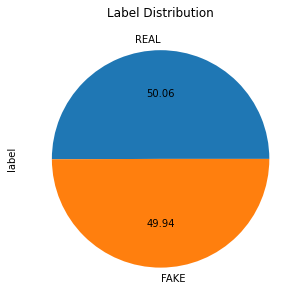

In [7]:
# Visualize the label coulmn

plt.figure(figsize =(10,5))
news['label'].value_counts(normalize=True).plot.pie(autopct="%.2f")
plt.title("Label Distribution");

There is an even distribution of observations among the Label, hence, the dataset is Balanced.

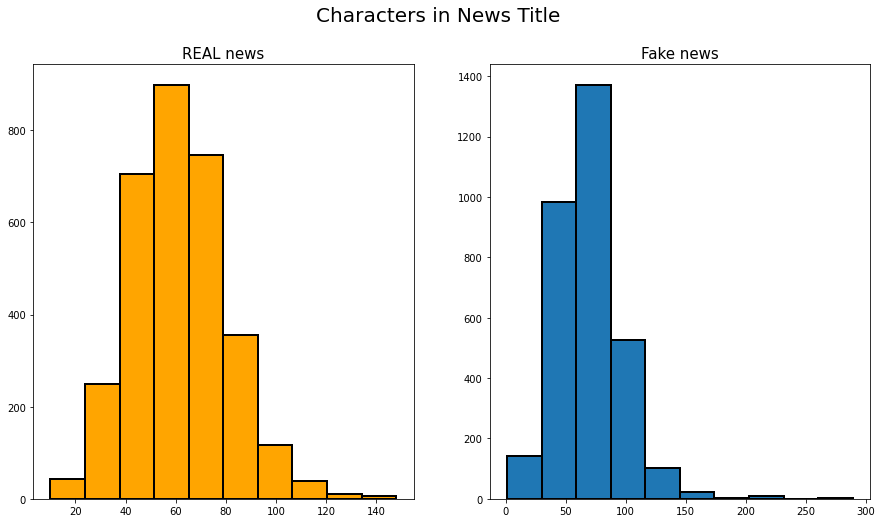

In [8]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,8))
fig.suptitle('Characters in News Title',fontsize=20)
news_len=news[news['label']=='REAL']['title'].str.len()
ax1.hist(news_len,color='orange',linewidth=2,edgecolor='black')
ax1.set_title('REAL news',fontsize=15)
news_len=news[news['label']=='FAKE']['title'].str.len()
ax2.hist(news_len,linewidth=2,edgecolor='black')
ax2.set_title('Fake news',fontsize=15);

Characters in News Title with length 60 are more in the 'Real' news Label, and Title length between 50 and 100 are more in the 'Fake' news Label. Statistically, this is a Right-Skewed or Positive-Skewed distribution (Mean > Median > Mode)

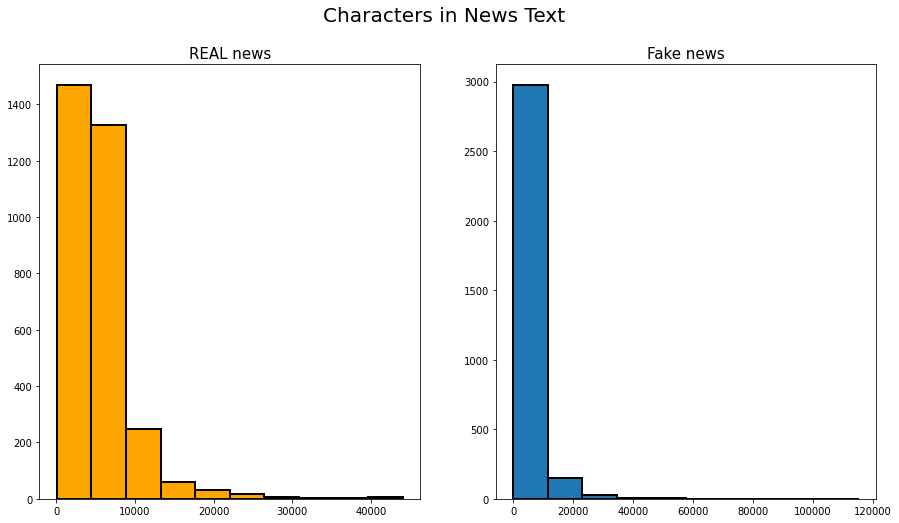

In [151]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,8))
fig.suptitle('Characters in News Text',fontsize=20)
news_len=news[news['label']=='REAL']['text'].str.len()
ax1.hist(news_len,color='orange',linewidth=2,edgecolor='black')
ax1.set_title('REAL news',fontsize=15)
news_len=news[news['label']=='FAKE']['text'].str.len()
ax2.hist(news_len,linewidth=2,edgecolor='black')
ax2.set_title('Fake news',fontsize=15);

Characters in News Text with length between 0 and 5000 are more in the 'Real' news Label, and Text length between 0 and 10000 are more in the 'Fake' news Label. Statistically, this is a Right-Skewed or Positive-Skewed distribution (Mean > Median > Mode)


A Fake News cannot be deduced or detected or presumed by just the Text or Title Character Length

In [158]:
# Average of Characters in News Text

mean_text_real = round(news[news['label']=='REAL']['text'].str.len().mean())
mean_text_fake = round(news[news['label']=='FAKE']['text'].str.len().mean())

print("Average Text Length for Real: ", mean_text_real)
print("Average Text Length for Fake: ", mean_text_fake)



Average Text Length for Real:  5292
Average Text Length for Fake:  4121


In [170]:
# Average of Characters in News Title

mean_title_real = round(news[news['label']=='REAL']['title'].str.len().mean())
mean_title_fake = round(news[news['label']=='FAKE']['title'].str.len().mean())

print("Average Title Length for Real: ", mean_title_real)
print("Average Title Length for Fake: ", mean_title_fake)


Average Title Length for Real:  61
Average Title Length for Fake:  69


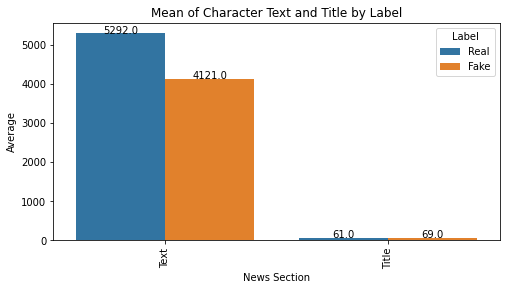

In [180]:
# Create a df for the character text and title mean of the labels for visualization
df = [['Text', 'Real', 5292],['Text', 'Fake', 4121],['Title', 'Real', 61],['Title', 'Fake', 69]]

df_plt = pd.DataFrame(df, columns=['Section','Label', 'Average'])


# Visualization
fig, ax1 = plt.subplots(figsize = (8,4))
plt.ticklabel_format(style='plain')
viz = sns.barplot(ax =ax1, x='Section', y= 'Average', hue= 'Label', data = df_plt)
viz.set_xticklabels(viz.get_xticklabels(), rotation=90)
for i in viz.patches:
    height = i.get_height()
    viz.text(i.get_x() + i.get_width()/2., height + 0.1, height, ha="center")
plt.title("Mean of Character Text and Title by Label")
plt.xlabel("News Section")
plt.ylabel("Average")
plt.show();


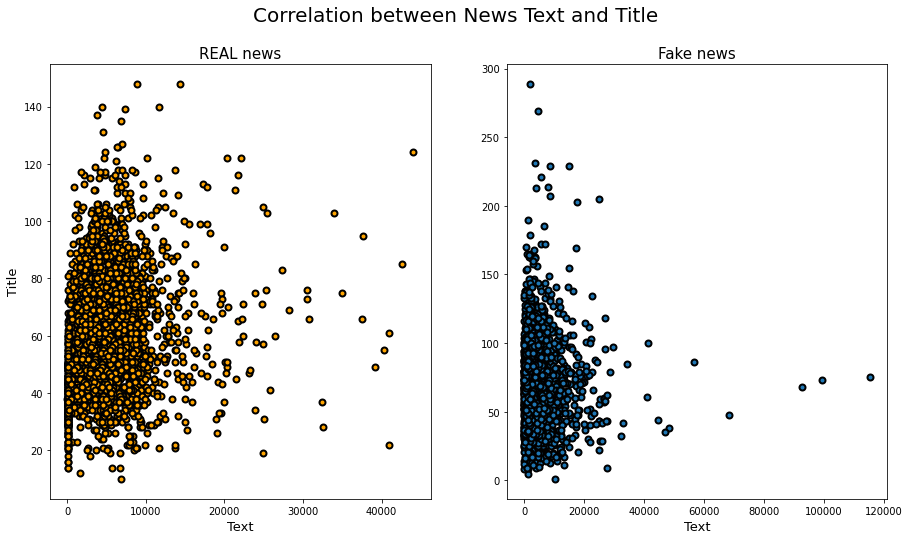

In [184]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,8))
fig.suptitle('Correlation between News Text and Title',fontsize=20)
news_lenRTl=news[news['label']=='REAL']['title'].str.len()
news_lenRTx=news[news['label']=='REAL']['text'].str.len()
ax1.scatter(x=news_lenRTx,y =news_lenRTl, color='orange',linewidth=2,edgecolor='black')
ax1.set_title('REAL news',fontsize=15)
ax1.set_xlabel("Text", fontsize=13)
ax1.set_ylabel("Title", fontsize=13)
news_lenFTl=news[news['label']=='FAKE']['title'].str.len()
news_lenFTx=news[news['label']=='FAKE']['text'].str.len()
ax2.scatter(x = news_lenFTx, y=news_lenFTl, linewidth=2,edgecolor='black')
ax2.set_title('Fake news',fontsize=15)
ax2.set_xlabel("Text", fontsize=13)
ax1.set_ylabel("Title", fontsize=13);

There is no distinct relationship between Text and Title in both Labels, though it is observed that majority of the data are between: Real news labels - Text length of 0 - 10000 with Title length of 20 - 100; Fake news labels - Text length of 0 - 10900 with Title length of 0 - 150;

### Splitting data 

Splitting the data into training and testing data.

In [10]:

x_train,x_test,y_train,y_test=train_test_split(news['text'],news['label'],test_size=0.2)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(5068,)
(1267,)
(5068,)
(1267,)


### TF-IDFVectorizer
The TF-IDFVectorizer converts a collection of raw documents into a matrix of TF-IDF features.
##### TF (Term Frequency): 
The number of times a word appears in a document is its Term Frequency. A higher value means a term appears more often than others, and so, the document is a good match when the term is part of the search terms.

##### IDF (Inverse Document Frequency): 
Words that occur many times a document, but also occur many times in many others, may be irrelevant. IDF is a measure of how significant a term is in the entire corpus.

In [11]:
tfidf=TfidfVectorizer(stop_words='english',max_df=0.8)
x_train=tfidf.fit_transform(x_train)
x_test=tfidf.transform(x_test)
print(x_test.shape)
print(x_train.shape)

(1267, 61186)
(5068, 61186)


# 3. Model Building


We have to build a model to accurately classify a piece of news as REAL or FAKE.

Using six models Light Gradient Boosting, Decision Tree, K-NN, RandomForestClassifier, SVC, LogisticRegression  to compare the accuracy of these models. It will help to find which model fits the data and predict real and fake news accurately.

Also cross validation will be done using the GridSearchCV 

## 3.1. Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression


In [13]:
params_LR = {'C' : [10, 5, 1,0.7, 0.5,0.3]}

# C = 0.5 gives the best result after Grid Search.



In [14]:
clf_LR = GridSearchCV(estimator = LogisticRegression(class_weight = 'balanced', random_state = 6),param_grid = params_LR, 
                      cv = 3, refit = True, scoring = 'accuracy', n_jobs = 4)

In [15]:
clf_LR.fit(x_train,y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=6),
             n_jobs=4, param_grid={'C': [10, 5, 1, 0.7, 0.5, 0.3]},
             scoring='accuracy')

In [16]:
clf_LR.best_score_

0.9281772181758519

In [17]:
clf_LR.best_params_

{'C': 10}

In [18]:
pred_LR = clf_LR.predict(x_test)

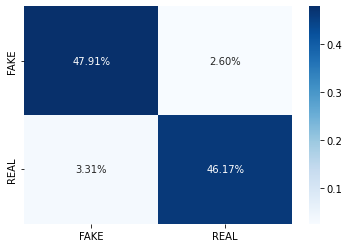

In [19]:
cm_LR = confusion_matrix(y_test,pred_LR, labels = ['FAKE', 'REAL'])
sns.heatmap(cm_LR/ np.sum(cm_LR),fmt='.2%', annot=True, cmap = 'Blues', xticklabels = ['FAKE', 'REAL'], yticklabels = ['FAKE', 'REAL']);


In [20]:

report_LR = classification_report(y_test,pred_LR, labels = ['FAKE','REAL'], output_dict = True)
report_LR = pd.DataFrame(report_LR).transpose()
report_LR

,precision,recall,f1-score,support
FAKE,0.935285,0.948438,0.941815,640.000000
REAL,0.946602,0.933014,0.939759,627.000000
accuracy,0.940805,0.940805,0.940805,0.940805
macro avg,0.940943,0.940726,0.940787,1267.000000
weighted avg,0.940885,0.940805,0.940798,1267.000000


## 3.2. K-Nearest Neighbor Method

In [21]:
# Here we are iteratively doing grid search with different hyperparameters in an informed manner.
# params_knn = {'n_neighbors' : [2, 4, 8, 16] } # We obtain 4 as the best hyperparameter.
params_knn = {'n_neighbors' : [3,4,5,6,7] }     # 5 is the final tuned hyperparameter.

In [22]:
clf_knn = GridSearchCV(estimator = KNeighborsClassifier(algorithm = 'ball_tree'), param_grid = params_knn, 
                       scoring = 'accuracy', n_jobs = 4, cv = 3, refit = True, verbose = 3)

In [23]:
clf_knn.fit(x_train,y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(algorithm='ball_tree'),
             n_jobs=4, param_grid={'n_neighbors': [3, 4, 5, 6, 7]},
             scoring='accuracy', verbose=3)

In [24]:
clf_knn.best_score_

0.5706392330931203

In [25]:
clf_knn.best_params_

{'n_neighbors': 3}

In [26]:
pred_knn = clf_knn.predict(x_test)

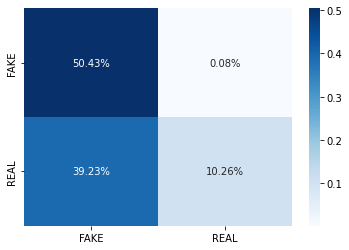

In [27]:
cm_knn = confusion_matrix(y_test,pred_knn, labels = ['FAKE', 'REAL'])
sns.heatmap(cm_knn/ np.sum(cm_knn),fmt='.2%', annot=True, cmap = 'Blues', xticklabels = ['FAKE', 'REAL'], yticklabels = ['FAKE', 'REAL']);


In [29]:

report_knn = classification_report(y_test,pred_knn, labels = ['FAKE','REAL'], output_dict = True)
report_knn = pd.DataFrame(report_knn).transpose()
report_knn

,precision,recall,f1-score,support
FAKE,0.562500,0.998437,0.719595,640.000000
REAL,0.992366,0.207337,0.343008,627.000000
accuracy,0.606946,0.606946,0.606946,0.606946
macro avg,0.777433,0.602887,0.531301,1267.000000
weighted avg,0.775228,0.606946,0.533233,1267.000000


## 3.3. Support Vector Machine Classifier

In [30]:
# Here we are iteratively doing grid search with different hyperparameters in an informed manner.
# params_svc = {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'], 'C' : [0.1, 1, 50]} # 'rbf' and 50 give the best combination
# params_svc = {'kernel' : ['rbf', 'sigmoid'], 'C' : [10, 30, 50,100]}  # 100 and 'rbf' give the best combination.
params_svc = {'kernel' : ['rbf', 'sigmoid'], 'C' : [100, 150, 200]}   # 100 and 'rbf' give the best combination.

In [31]:
clf_svc = GridSearchCV(estimator = SVC(class_weight = 'balanced', random_state = 6), param_grid = params_svc, 
                       scoring = 'accuracy', n_jobs = 4, cv = 3, refit = True, verbose = 2)

In [32]:
clf_svc.fit(x_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=SVC(class_weight='balanced', random_state=6),
             n_jobs=4,
             param_grid={'C': [100, 150, 200], 'kernel': ['rbf', 'sigmoid']},
             scoring='accuracy', verbose=2)

In [33]:
clf_svc.best_params_

{'C': 100, 'kernel': 'rbf'}

In [34]:
clf_svc.best_score_

0.9262035470260638

In [35]:
pred_svc = clf_svc.predict(x_test)

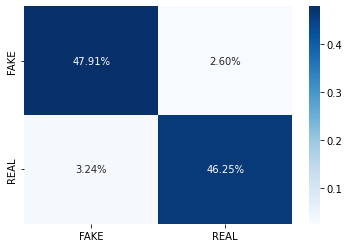

In [36]:
cm_svc = confusion_matrix(y_test, pred_svc, labels = ['FAKE', 'REAL'])
sns.heatmap(cm_svc/ np.sum(cm_svc),fmt='.2%', annot=True, cmap = 'Blues', xticklabels = ['FAKE', 'REAL'], yticklabels = ['FAKE', 'REAL']);


In [38]:

report_svc = classification_report(y_test, pred_svc, labels = ['FAKE','REAL'], output_dict = True)
report_svc = pd.DataFrame(report_svc).transpose()
report_svc

,precision,recall,f1-score,support
FAKE,0.936728,0.948438,0.942547,640.000000
REAL,0.946688,0.934609,0.940610,627.000000
accuracy,0.941594,0.941594,0.941594,0.941594
macro avg,0.941708,0.941523,0.941578,1267.000000
weighted avg,0.941657,0.941594,0.941588,1267.000000


## 3.4. Decision Tree Classifier

In [39]:
params_dt = {'criterion' : ['entropy'], 'min_samples_split' : [2, 4, 8, 16, 32], 
             'min_samples_leaf' : [1,2,4,8],'max_depth' : [4, 7, 10], 'max_features' : ['sqrt', None],  'class_weight' : ['balanced']}

# (max_depth = 7, min_samples_leaf = 4, min_samples_split = 32, max_features = None) give the best result.

In [40]:
clf_dt = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 7), param_grid = params_dt, 
                      scoring = 'accuracy', n_jobs = 4, cv = 3, refit = True, verbose = 3)

In [41]:
clf_dt.fit(x_train, y_train)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=7), n_jobs=4,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [4, 7, 10],
                         'max_features': ['sqrt', None],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 4, 8, 16, 32]},
             scoring='accuracy', verbose=3)

In [42]:
clf_dt.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': None,
 'min_samples_leaf': 8,
 'min_samples_split': 32}

In [43]:
clf_dt.best_score_

0.8103776261994599

In [44]:
pred_dt = clf_dt.predict(x_test)

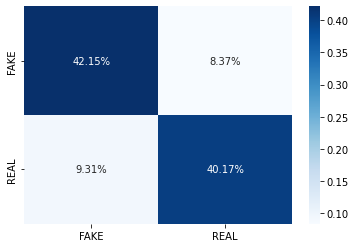

In [45]:
cm_dt = confusion_matrix(y_test, pred_dt, labels = ['FAKE', 'REAL'])
sns.heatmap(cm_dt/ np.sum(cm_dt),fmt='.2%', annot=True, cmap = 'Blues', xticklabels = ['FAKE', 'REAL'], yticklabels = ['FAKE', 'REAL']);


In [46]:

report_dt = classification_report(y_test, pred_dt, labels = ['FAKE','REAL'], output_dict = True)
report_dt = pd.DataFrame(report_dt).transpose()
report_dt

,precision,recall,f1-score,support
FAKE,0.819018,0.834375,0.826625,640.000000
REAL,0.827642,0.811802,0.819646,627.000000
accuracy,0.823204,0.823204,0.823204,0.823204
macro avg,0.823330,0.823089,0.823136,1267.000000
weighted avg,0.823286,0.823204,0.823171,1267.000000


## 3.5. Random Forest Classifier

In [47]:
params_RF = {'n_estimators' : [400, 1000, 1600], 'criterion' : ['entropy'], 'min_samples_split' : [2, 4, 8, 16], 
             'min_samples_leaf' : [1,2], 'class_weight' : ['balanced']}  

# (min_samples_leaf = 1, min_samples_split = 4 , n_estimators = 1000) give the best result.

In [48]:
clf_RF = GridSearchCV(estimator = RandomForestClassifier(oob_score = True, random_state = 7), param_grid = params_RF, 
                      scoring = 'accuracy', n_jobs = 4, cv = 3, refit = True, verbose = 2)

In [49]:
clf_RF.fit(x_train,y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(oob_score=True, random_state=7),
             n_jobs=4,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4, 8, 16],
                         'n_estimators': [400, 1000, 1600]},
             scoring='accuracy', verbose=2)

In [50]:
clf_RF.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 16,
 'n_estimators': 1600}

In [51]:
clf_RF.best_score_

0.9056816178007597

In [52]:
pred_RF = clf_RF.predict(x_test)

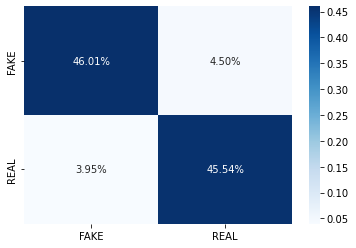

In [53]:
cm_RF = confusion_matrix(y_test, pred_RF, labels = ['FAKE', 'REAL'])
sns.heatmap(cm_RF/ np.sum(cm_RF),fmt='.2%', annot=True, cmap = 'Blues', xticklabels = ['FAKE', 'REAL'], yticklabels = ['FAKE', 'REAL']);


In [54]:

report_RF = classification_report(y_test, pred_RF, labels = ['FAKE','REAL'], output_dict = True)
report_RF = pd.DataFrame(report_RF).transpose()
report_RF

,precision,recall,f1-score,support
FAKE,0.921011,0.910937,0.915947,640.000000
REAL,0.910095,0.920255,0.915147,627.000000
accuracy,0.915549,0.915549,0.915549,0.915549
macro avg,0.915553,0.915596,0.915547,1267.000000
weighted avg,0.915609,0.915549,0.915551,1267.000000


## 3.6. Light Gradient Boosting Method 

In [55]:

# Let's just try with n_estimators 3600.
params_lgb = {'n_estimators' : [3600], 'learning_rate' : [ 0.1], 'min_child_samples' : [1,2]} 
# (n_estimators = 3600, learning_rate = 0.1, min_child_samples = 1) perform best.

In [56]:
clf_lgb = GridSearchCV(estimator = lgb.LGBMClassifier(), param_grid = params_lgb, scoring = 'accuracy', n_jobs = 4,
                       cv = 3, refit = True, verbose = 2)

In [59]:
clf_lgb.fit(x_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


GridSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=4,
             param_grid={'learning_rate': [0.1], 'min_child_samples': [1, 2],
                         'n_estimators': [3600]},
             scoring='accuracy', verbose=2)

In [60]:
clf_lgb.best_params_

{'learning_rate': 0.1, 'min_child_samples': 1, 'n_estimators': 3600}

In [61]:
print(clf_lgb.best_score_)

0.9307422549668759


In [62]:
pred_lgb = clf_lgb.predict(x_test)   



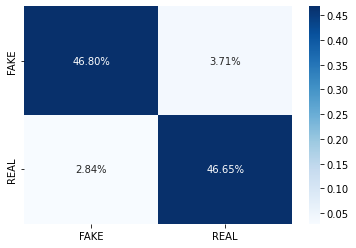

In [63]:
cm_lgb = confusion_matrix(y_test, pred_lgb, labels = ['FAKE', 'REAL'])
sns.heatmap(cm_lgb/ np.sum(cm_lgb),fmt='.2%', annot=True, cmap = 'Blues', xticklabels = ['FAKE', 'REAL'], yticklabels = ['FAKE', 'REAL']);


In [64]:
from sklearn.metrics import classification_report

report_lgb = classification_report(y_test, pred_lgb, labels = ['FAKE','REAL'], output_dict = True)
report_lgb = pd.DataFrame(report_lgb).transpose()
report_lgb

,precision,recall,f1-score,support
FAKE,0.942766,0.926562,0.934594,640.000000
REAL,0.926332,0.942584,0.934387,627.000000
accuracy,0.934491,0.934491,0.934491,0.934491
macro avg,0.934549,0.934573,0.934491,1267.000000
weighted avg,0.934634,0.934491,0.934492,1267.000000


## Summary of  the different Model Performance based on accuracy, precision, recall and f1-score

In [83]:
# for easy ML training the label column will be converted to numeric values, using the replace(), 0 = FAKE AND 1 = REAL

news['label'].replace(['FAKE', 'REAL'],
                        [0, 1], inplace=True)

In [85]:
x_train,x_test,y_train,y_test=train_test_split(news['text'],news['label'],test_size=0.2)

tfidf=TfidfVectorizer(stop_words='english',max_df=0.8)
x_train=tfidf.fit_transform(x_train)
x_test=tfidf.transform(x_test)

In [87]:
# Initialization, training and testing using the GridSearchcv passed models

classifiers = [
    [clf_LR, 'Logistic Regression'], [clf_knn, 'K-Nearest Neighbors'], [clf_svc, 'SVC'], [clf_dt, 'Decision Trees'], 
    [clf_RF, 'Random Forest'], [clf_lgb, 'Light Gradient Boosting']
]

accuracy_list = {}
precision_list = {}
recall_list = {}
f1_list = {}

for classifier in classifiers:
    model = classifier[0]
    model.fit(x_train, y_train)
    model_name = classifier[1]
    
    pred = model.predict(x_test)
    
    a_score = accuracy_score(y_test, pred)
    p_score = precision_score(y_test, pred)
    r_score = recall_score(y_test, pred)
    f_score = f1_score(y_test, pred)
    
    accuracy_list[model_name] = [str(round(a_score*100, 2)) + '%']
    precision_list[model_name] = [str(round(p_score*100, 2)) + '%']
    recall_list[model_name] = [str(round(r_score*100, 2)) + '%']
    f1_list[model_name] = [str(round(f_score*100,2)) + '%']
    
    if model_name != classifiers[0][1]:
        print('')

Fitting 3 folds for each of 5 candidates, totalling 15 fits

Fitting 3 folds for each of 6 candidates, totalling 18 fits

Fitting 3 folds for each of 120 candidates, totalling 360 fits

Fitting 3 folds for each of 24 candidates, totalling 72 fits

Fitting 3 folds for each of 2 candidates, totalling 6 fits



In [91]:
# Print Accuracy, Precision, Recall anf F1 Scores for each Model 

print("Accuracy Scores of Models")
report1 = pd.DataFrame(accuracy_list)
report1.head()

Accuracy Scores of Models


,Logistic Regression,K-Nearest Neighbors,SVC,Decision Trees,Random Forest,Light Gradient Boosting
0,92.27%,60.3%,92.5%,81.45%,91.24%,93.84%


In [92]:
print("Precision Scores of Models")
report2 = pd.DataFrame(precision_list)
report2.head()

Precision Scores of Models


,Logistic Regression,K-Nearest Neighbors,SVC,Decision Trees,Random Forest,Light Gradient Boosting
0,93.17%,98.46%,94.5%,84.08%,91.77%,94.36%


In [93]:
print("Recall Scores of Models")
report3 = pd.DataFrame(recall_list)
report3.head()

Recall Scores of Models


,Logistic Regression,K-Nearest Neighbors,SVC,Decision Trees,Random Forest,Light Gradient Boosting
0,91.1%,20.35%,90.14%,77.27%,90.46%,93.16%


In [94]:
print("F1 Scores of Models")
report4 = pd.DataFrame(f1_list)
report4.head()

F1 Scores of Models


,Logistic Regression,K-Nearest Neighbors,SVC,Decision Trees,Random Forest,Light Gradient Boosting
0,92.12%,33.73%,92.27%,80.53%,91.11%,93.76%


### Visualization of the Evaluation Metrics

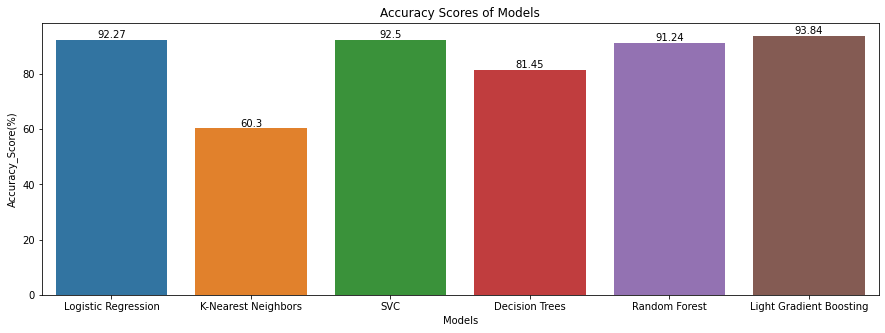

In [138]:
# Accuracy Score

a_d = [['Logistic Regression',92.27],['K-Nearest Neighbors',60.3],['SVC',92.5],['Decision Trees',81.45], 
     ['Random Forest',91.24], ['Light Gradient Boosting', 93.84]]

a_plt = pd.DataFrame(a_d, columns=['Models','Accuracy_Score'])


plt.figure(figsize=(15,5))
ax = sns.barplot(x='Models', y= 'Accuracy_Score', data = a_plt)
values = a_plt['Accuracy_Score'].values
ax.bar_label(container = ax.containers[0], labels=values)
plt.title("Accuracy Scores of Models")
plt.xlabel("Models")
plt.ylabel("Accuracy_Score(%)");

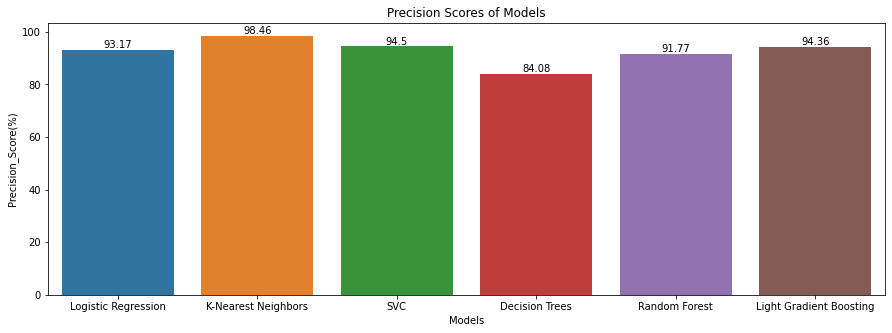

In [137]:
# Precision Score

p_d = [['Logistic Regression',93.17],['K-Nearest Neighbors',98.46],['SVC',94.5],['Decision Trees',84.08], 
     ['Random Forest',91.77], ['Light Gradient Boosting', 94.36]]

p_plt = pd.DataFrame(p_d, columns=['Models','Precision_Score'])


plt.figure(figsize=(15,5))
ax = sns.barplot(x='Models', y= 'Precision_Score', data = p_plt)
values = p_plt['Precision_Score'].values
ax.bar_label(container = ax.containers[0], labels=values)
plt.title("Precision Scores of Models")
plt.xlabel("Models")
plt.ylabel("Precision_Score(%)");

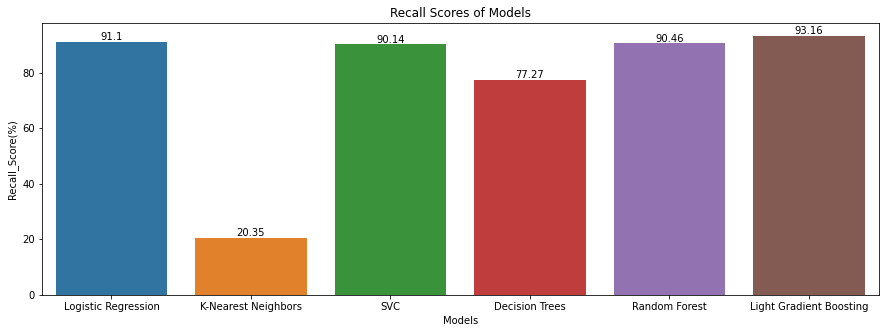

In [136]:
# Recall Score

r_d = [['Logistic Regression',91.1],['K-Nearest Neighbors',20.35],['SVC',90.14],['Decision Trees',77.27], 
     ['Random Forest',90.46], ['Light Gradient Boosting', 93.16]]

r_plt = pd.DataFrame(r_d, columns=['Models','Recall_Score'])


plt.figure(figsize=(15,5))
ax = sns.barplot(x='Models', y= 'Recall_Score', data = r_plt)
values = r_plt['Recall_Score'].values
ax.bar_label(container = ax.containers[0], labels=values)
plt.title("Recall Scores of Models")
plt.xlabel("Models")
plt.ylabel("Recall_Score(%)");

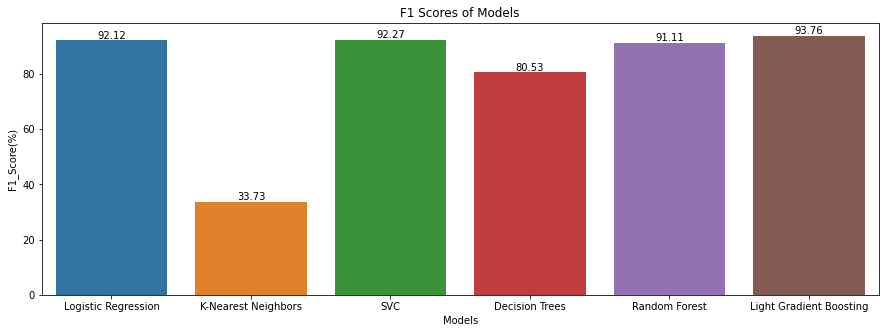

In [135]:
# F1 Score

f1_d = [['Logistic Regression',92.12],['K-Nearest Neighbors',33.73],['SVC',92.27],['Decision Trees',80.53], 
     ['Random Forest',91.11], ['Light Gradient Boosting', 93.76]]

f1_plt = pd.DataFrame(f1_d, columns=['Models','F1_Score'])


plt.figure(figsize=(15,5))
ax = sns.barplot(x='Models', y= 'F1_Score', data = f1_plt)
values = f1_plt['F1_Score'].values
ax.bar_label(container = ax.containers[0], labels=values)
plt.title("F1 Scores of Models")
plt.xlabel("Models")
plt.ylabel("F1_Score(%)");


##  Conclusion

For this classification project, 6 ML Algorithms (Light Gradient Boosting, Decision Tree, K-Nearest Neighbors, RandomForestClassifier, SVC, and LogisticRegression) were trained and tested with the news dataset, using the the evaluation metrics - Accuracy, Precision, Recall and F1. It's observed that some models did better than some with respect to the different metrics. For this project, the evaluation metric used for the basis of model's best performance is Accuracy (evaluating the overall performance of the model in correctly classifying Fake and Real News), and F1_Score (combining precision and recall using their harmonic mean - how well the models predicts negative / positive values).

The model Light Gradient Boosting performed best judging from both F1_score and Accuracy, with F1_score of 93.76% and Accuracy Score of 93.84%, followed by SVC with F1_score of 92.27% and Accuracy Score of 92.50%. 

It is recommended that this model(s) be deployed for the detection and control of Fake News.